# Assignment 4
Training a simple neural net for relation classification.

In [1]:
!pip install transformers
!pip install torchinfo
!pip install torch-info
!pip install torchsummary


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: Could not find a version that satisfies the requirement torch-info (from versions: none)
ERROR: No matching distribution found for torch-info
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import torch
import torch.nn as nn
from google.colab import drive
import torch
import torch.nn as nn
import tensorflow as tf
import os
import numpy as np
import math
from tabulate import tabulate

from sklearn.metrics import classification_report
from transformers import get_linear_schedule_with_warmup
from transformers import BertTokenizer
from transformers import BertForSequenceClassification
from transformers import AutoConfig, AutoModel
from torchsummary import summary
from numpy.random import default_rng
import gc
import pandas as pd 
from tqdm.notebook import tqdm_notebook
from IPython.display import display
import warnings
from sklearn.metrics import f1_score
warnings.filterwarnings("ignore")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# from IPython.display import displa



## display on which device the model will be trained

In [3]:
print(device)

cuda


In this assignment you are required :
## to build a full training and testing pipeline for a neural relation classification (RC), using BERT.

1. The dataset that you will be working on is called SemEval Task 8 dataset (https://arxiv.org/pdf/1911.10422v1.pdf). 
2. The dataset contain only train and test split, but you are allowed to split the train dataset into dev if needed.
3. The two files (train and test) are available from the course git repository (https://github.com/kfirbar/nlp-course)
4. In this work we will use the hugingface framework for transformers training and inference.
5. We recomand reading the d4.ocumentation in https://huggingface.co/transformers/model_doc/bert.html#bertforsequenceclassification *before* you start coding. 


## Task 1 - read data : 
Write a funtion *read_data* for reading the data from a single file (either train or test). 
1. This function recieves a filepath and returns a list of sentence.
2. Every sentence is encoded as a touple
    * first element is the sentence string
    * second the label (also represented as a sting). 

In [4]:
# !git clone https://github.com/kfirbar/nlp-course

In [5]:
# general folder path
drive_path = '/content/gdrive'
drive_saving_path = '/content/gdrive/My Drive'
drive.mount(drive_path)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [6]:
User = 'Drive'

if User == 'Or':
    main_folder =  r'C:\MSC\NLP2\HW4'

    train_path = r'C:\MSC\NLP2\HW4\TRAIN_FILE.TXT'
    test_path = r'C:\MSC\NLP2\HW4\TEST_FILE_FULL.txt'
    BERT_CHECKPOINT = os.path.join(main_folder, 'BERT_CHECKPOINT')

else:
    main_folder = os.path.join(drive_saving_path, 'NLP4')
    train_path = os.path.join(main_folder, 'TRAIN_FILE.TXT')
    test_path = os.path.join(main_folder, 'TEST_FILE_FULL.TXT')

    BERT_CHECKPOINT = os.path.join(main_folder, 'BERT_CHECKPOINT')

   


In [7]:

def read_data(filepath):
    """
    Parameters
    ----------
    filepath : string
    DESCRIPTION:
        1. for given path we read the txt file into list 
        2. for each sentence is shift of 4 index 0,4,8,....,4n, the label
           is the same only from the index 1,5,9,...4n+1
        3. first we will slice the sentences, and labels 
        4. for each setnence we will remodve the TAB & "\n" 
            ([1:-1] to remove the double quating ) 
        
          for each labels needed to remove  space and "\n"
        5. finnaly we need to concat setence to label to list of tupples 
    Returns
    -------
    data : list 
        list of tupples [ (sentence, label), (), ....].
    """
    # 1
    with open(filepath) as file:
        output = file.readlines()
    
    # 2
    STEP = 4
    
    # 3
    labels  = output[1::STEP]
    sentences  = output[0::STEP]

    #4 
    # sentence splited
    # sentences = list(map(lambda x: x.split('\t')[1].replace('\n', '')[1:-1], sentences))
    # labels = list(map(lambda x: x.replace('\n', ''), labels))
    sentences = list(map(lambda x: x.split('\t')[1].replace('\n', '').replace('</e2>', '').replace('</e1>', '').replace('<e1>', '').replace('<e2>', '')[1:-1], sentences))
    labels = list(map(lambda x: x.replace('\n', '').replace('(e2,e1)', '').replace('(e1,e2)', ''), labels))

    # 5
    data = list(zip(sentences, labels))
    
    return data

train = read_data(train_path)
test = read_data(test_path)

Pytorch require the labels to be integers. Create a mapper (dictionary) from the string labels to integers (starting zero). 

In [8]:
def from_list_of_list_2_single_list(list_of_list):
    # convertign list of list to single list with all ellements
    flat_list = [item for sublist in list_of_list for item in sublist]
    return flat_list

def get_unique_tokens_and_token_indexs(data, is_sentence = True):
    """
    Parameters
    ----------
    data : list of tuples 
        contain list of tuples (sentences, labels)
    is_sentence : Bollan
        indicate whether to get setnece or label
    
    
    1. get desire list sentences\labels 
    2. split into tokens
    3. convert to single list with all ellements
    4. doing unique the list to get unique value and index 
    5. generate dict\mapper from token 2 index
    
    Returns
    -------
    mapper_dict : dict
        map from unique token to unique index

    """
    #1
    if is_sentence:
        list_of_list = list(map(lambda x: x[0], data))

    # label
    else: 
        list_of_list = list(map(lambda x: x[1], data))
    
    #2
    list_of_list_tokens = list(map(lambda x: x.split(' '), list_of_list))
    #3
    all_tokens = from_list_of_list_2_single_list(list_of_list_tokens)
    #4
    unique_tokens =list(set(all_tokens))
    #5
    mapper_dict = dict(zip(unique_tokens,np.arange(0, unique_tokens.__len__())))
    return mapper_dict

def create_label_mapper(data):
    """
    Parameters
    ----------
    data : list of tuples 
        contain list of tuples (sentences, labels)
    Returns
    -------
    sentences_mapper : dict
        map from unique token to unique index
    labels_mapper : dict
        map from unique token to unique index
    """ 
    #sentences_mapper = get_unique_tokens_and_token_indexs(data, is_sentence = True)
    labels_mapper = get_unique_tokens_and_token_indexs(data, is_sentence = False)
    return labels_mapper

In [9]:
label_mapper = create_label_mapper(train)
labels = list(label_mapper.keys())
num_labels = labels.__len__()
label_mapper

{'Cause-Effect': 4,
 'Component-Whole': 6,
 'Content-Container': 1,
 'Entity-Destination': 9,
 'Entity-Origin': 8,
 'Instrument-Agency': 5,
 'Member-Collection': 3,
 'Message-Topic': 2,
 'Other': 0,
 'Product-Producer': 7}

## Task 2  - prepare data : 
Write a function *prepare_data* that 
1. takes one of the [train, test] datasets and convert each pair of (words,labels) to a pair of indexes. 
2. The function also aggregate the samples into batches. 
3. BERT Uses pretrained tokanization and embedding. 
4. you can access the tokanization and indexing using the BertTokenizer class.


In [10]:
def get_single_input(i_data, label_tuple_idx, labels_mapper, sentence_tuple_idx, tokenizer, num_labels = 10, remove_entity = False):
    """
    getting tuple size 3 base data item  (tensor input, mask tensor, label iteger)
    """
    # get setnece and label
    i_sentence = i_data[sentence_tuple_idx]
    i_label = i_data[label_tuple_idx]

    if remove_entity:
      i_sentence = list(map(lambda x: x.replace('</e2>', '').replace('</e1>', '').replace('<e1>', '').replace('<e2>', ''), i_sentence))
      
    # do tokenization to the setnence
    i_tensor_input = tokenizer(i_sentence,  truncation=True,   padding='max_length',return_tensors="pt")

    i_tensor_input = list(i_tensor_input.values())
    # get label
    i_label = labels_mapper[i_label]
    # print(i_label)
    label_array = np.zeros((1,num_labels))
    label_array[0,int(i_label)] = 1 
    i_label = torch.tensor([i_label])
    # i_label = torch.tensor(label_array)

    # insert all to tupple
    # single_input = (input_ids, attn_mask, i_label)
    # single_input = (i_tensor_input, i_label)

    return i_tensor_input, i_label

def prepare_data(data, tokenizer, batch_size=8, num_labels = 10, remove_entity = False):
    """
    Parameters
    ----------
    data : list of tuples 
        contain list of tuples (sentences, labels)
    tokenizer : generator of transformers pakage
        for given sentence return dict of:
            1. input idx - tensor
            2. mask  - tensor 
            3. attention_mask - tensor
            
    batch_size : int, optional
        DESCRIPTION. The default is 8, the size of batch, after 8 input model will do backprop'.

    Returns
    -------
    data_sequences : list of tuples 
        the input to our model

    """
    data_sequences = []
    sentence_tuple_idx = 0
    label_tuple_idx = 1

    labels_mapper = create_label_mapper(data)
    for sentence_idx, i_data in enumerate(data):
      
            
        # 
        i_tensor_input, i_label = get_single_input(i_data, label_tuple_idx, labels_mapper, sentence_tuple_idx, tokenizer, num_labels, remove_entity)


        # initiate batch input list
        if sentence_idx ==0 or ids_tensor.shape[0]%batch_size == 0 :
            # print(sentence_idx)
            # print(batch_size)

            ids_tensor = i_tensor_input[0]
            idx_tensor = i_tensor_input[1]
            attention_mask_tensor = i_tensor_input[2]
            label_tensor = i_label
        else:
            # append batch data
            # print(sentence_idx)
            ids_tensor = torch.concat((ids_tensor, i_tensor_input[0]), axis = 0)
            idx_tensor = torch.concat((idx_tensor, i_tensor_input[1]), axis = 0)
            attention_mask_tensor = torch.concat((attention_mask_tensor, i_tensor_input[2]), axis = 0)
            label_tensor = torch.concat((label_tensor, i_label), axis = 0)

        # if batch list is fill append batch data to all data 
        if ids_tensor.shape[0]%(batch_size) == 0:
            batch_data = [[ids_tensor, idx_tensor, attention_mask_tensor], label_tensor]
            data_sequences.append(batch_data)
    
    padd_last_batch_size =  8 - ids_tensor.shape[0] 
    if padd_last_batch_size>0:
        rng = default_rng()
        choosen_idx = \
            rng.choice(range(0, data.__len__()-padd_last_batch_size), size=padd_last_batch_size, replace=False)
        for i_idx in choosen_idx:
            
            i_data = data[i_idx]
            
            # get single input
            i_tensor_input, i_label = get_single_input(i_data, label_tuple_idx, labels_mapper, sentence_tuple_idx, tokenizer)
            
            # append batch data
            ids_tensor = torch.concat((ids_tensor, i_tensor_input[0]), axis = 0)
            idx_tensor = torch.concat((idx_tensor, i_tensor_input[1]), axis = 0)
            attention_mask_tensor = torch.concat((attention_mask_tensor, i_tensor_input[2]), axis = 0)
            label_tensor = torch.concat((label_tensor, i_label), axis = 0)


        # append batch data
        batch_data = [[ids_tensor, idx_tensor, attention_mask_tensor], label_tensor]
        data_sequences.append(batch_data)       

    return data_sequences

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
train_sequences = prepare_data(train, tokenizer)
test_sequences = prepare_data(test, tokenizer)

In [ ]:
train_sequences[0][0]

[tensor([[  101,  1996,  2291,  ...,     0,     0,     0],
         [  101,  1996, 30522,  ...,     0,     0,     0],
         [  101,  1996, 30522,  ...,     0,     0,     0],
         ...,
         [  101,  2023,  2003,  ...,     0,     0,     0],
         [  101,  1996,  2783,  ...,     0,     0,     0],
         [  101, 30522,  2111,  ...,     0,     0,     0]]),
 tensor([[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]),
 tensor([[1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         ...,
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0]])]

## Task 3 - get model parameters : 
In this part we classify the sentences using the BertForSequenceClassification model.
1. To save resources, we initialize the optimizer with the final layer of the model. 
2. You are also allowed to change the learning rate.

In [11]:
def get_parameters(params):
    """
    Parameters
    ----------
    params : pythorch model.named_parameters()

    Returns
    -------
    layers : TYPE
        DESCRIPTION.
    """
    # initiate layers 
    layers = []
    # run on all model layers 
    for name, param in params:
        # set when on which layer needed to do backprop'
        param.requires_grad = 'classifier' in name
        # append layer
        layers.append(param)
    return layers

## load  model


In [12]:
# constants
batch_size = 8
epochs = 80
lr = 1e-2

# define the tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

# set a bert model 
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=num_labels).to(device)

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

## print model summary

In [13]:
model

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

## set optimizer

In [14]:
# define the optimizer Adam  - is a fancy version of SGD)
optimizer = torch.optim.Adam(get_parameters(model.named_parameters()), lr=lr)

## Task 4 - set train loop  : 
Write a training loop
1. takes a BertForSequenceClassification model 
2. train for number of epochs to train on.
3. The loss is always CrossEntropyLoss 
4. optimizer is always Adam. 
5. You are allowed to split the train to train and dev sets.

In [15]:
def predict_batch_results(train_data):
  prediction_res = []
  for i_input in train_data:
    # get inputs
    i_input_ids = i_input['input_ids']
    i_attn_mask = i_input['attention_mask']
    i_token_type_ids = i_input['token_type_ids']

    # predict results
    logits = model(i_input_ids.to(device), i_attn_mask.to(device), i_token_type_ids.to(device))
    i_logits = logits['logits']

    # append results
    prediction_res.append(i_logits)
  return prediction_res



def get_model_results(model, test_sequences):
    """
    Parameters
    ----------
    model : Torch model  - 
        DESCRIPTION: LSTM model.
    test_sequences : list
        DESCRIPTION: input list of coupels [[word_tensor, lebel_tensor] , ...]
    
    the function get model results
    
    Returns
    -------
    all_test_words_pred : list
    all_test_words_true : list
    """
    # generate test tokens prediction
    all_test_words_pred = []
    all_test_words_true = []
    for sentence, labels in test_sequences:
        ids_tensor = sentence[0]
        idx_tensor = sentence[1]
        attention_mask_tensor = sentence[2]

        labels_tensor = labels.to(device)
        logits = model(ids_tensor.to(device), idx_tensor.to(device), attention_mask_tensor.to(device))
        logits = logits.logits
        
        _, pred_labels =logits.T.max(0)
        # _, labels =labels.T.max(0)

        all_test_words_pred += pred_labels.tolist()
        all_test_words_true += labels.tolist()

    return all_test_words_pred, all_test_words_true
def train_loop(model, n_epochs, train_data, label_mapper, dev_data = None, alpha_zero = 1e-2 ):
  """

    Parameters
    ----------
    model : torch model
        Bert model from transofrmers library.
    n_epochs : int
        amount of aphoces
    train_data : list
        list of batch of data each batch contain [input_ids,inputs_idx, input mask], label
    label_mapper : dict
        mapper from label name to labels index 
    dev_data : TYPE, optional
        list of batch of data each batch contain [input_ids,inputs_idx, input mask], label
    alpha_zero : float
        DESCRIPTION. intial learning rate - The default is 1e-3.

    discrition of functio:
        train the model for n_epochs, for each 5 aphocs the training caluclate
        his f-score results
    
    Returns
    -------
    model : torch model
       torch model after traning for n ephocs

  """
  update_lr_after_n_aphoc = 1  
  # alpha_zero = 1e-2
  # Loss function
  criterion = nn.CrossEntropyLoss()
  all_target_names = list(label_mapper.keys())

  optimizer = torch.optim.Adam(model.parameters(), lr=alpha_zero)

  
  curr_f1_accuracy_result = 0
  best_f1_accuracy_result = 0
  best_df = pd.DataFrame()
  old_lr  = alpha_zero
  for ephoc_index in range(1, n_epochs + 1):

    desc = ('Ephoc #' + str(ephoc_index))
    for sequence_idx in tqdm_notebook(range(train_data.__len__()), desc = desc):
        
        
        # get sentence tokens, and labels 
        batch_data =  train_data[sequence_idx]

        # get batch label and data 
        i_batch_data =  batch_data[0]
        i_batch_data_labels = batch_data[1]

        # input_ids_train ,train_attention_mask, train_labels = train_sequences[sequence_idx]
        if not dev_data is None:
            dev_sentence ,dev_mask, dev_labels = train_sequences[sequence_idx]

        # check if there is empty sentence
        if i_batch_data.__len__() == 0:
            continue
    
        
        # Sets the gradients of all optimized to zero.
        model.zero_grad()
        
        # foward sentence to model
        ids_tensor = i_batch_data[0]
        idx_tensor = i_batch_data[1]
        attention_mask_tensor = i_batch_data[2]

        # foward inputs in the model 
        logits = model(ids_tensor.to(device), idx_tensor.to(device), attention_mask_tensor.to(device))
        logits = logits.logits

        # Computes the gradient of current tensor
        criterion(logits, i_batch_data_labels.to(device)).backward()
        
        # Clip the norm of the gradients to 1.0 to prevent "exploding gradients"
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # once the gradients are computed use them to optimize model
        optimizer.step()
    
    # update lr rate
    cos_inner = np.pi * (ephoc_index % (n_epochs // update_lr_after_n_aphoc))  
    cos_inner /= n_epochs // update_lr_after_n_aphoc
    cos_out = np.cos(cos_inner) + 1
    new_lr = float(alpha_zero / 2 * cos_out) # needed to be seen
    lr_string = '\nlearning rate we decay from value = ' + str(new_lr) + ' to the value = '+ str(old_lr)
    old_lr  = new_lr

    # update optimizer lr update apdating the lr
    optimizer = torch.optim.Adam(model.parameters(), lr=new_lr)

    # free memory from the GPU
    torch.cuda.empty_cache()
    gc.collect()
    
    # for any 5 ephoces show results, whether model is improved  
    if ephoc_index%5== 0 and  ephoc_index != 0:
      
      print('finshed ephoc #' + str(ephoc_index) + ', ephoch results:' , flush = True)
      # get f1 score for i ephoc
      all_train_words_pred, all_train_words_true = get_model_results(model, train_sequences)
      curr_f1_accuracy_result = f1_score(all_train_words_true, all_train_words_pred,  average='macro')

      # state if accuracy results was improved
      if curr_f1_accuracy_result > best_f1_accuracy_result:
        improve_string = 'f1-accuracy-score improve from ' + str(best_f1_accuracy_result) + ' to ' + str(curr_f1_accuracy_result) 
        best_f1_accuracy_result = curr_f1_accuracy_result
        torch.save(model.state_dict(), BERT_CHECKPOINT + '_last.pth' )

        # best_df = train_Results_df
      else:
        improve_string = 'f1-accuracy-score did not improve from ' + str(best_f1_accuracy_result)  
      improve_string += lr_string
      print(improve_string, flush = True)
      
    # release memory 
    torch.cuda.empty_cache()
    gc.collect()
    
  return model 

## Task 5 - train and evaluation:
write an evaluation loop on a trained model, using the dev and test datasets. 
1. This function print the true positive rate (TPR), also known as Recall 
2. the opposite to false positive rate (FPR), also known as precision, of each label seperately (10 labels in total)
3.  and for all labels together. The caption argument for the function should be served for printing, so that when you print include it as a prefix.

## set evaluation  

In [16]:
def evaluate(model, test_data):
    """
    

    Parameters
    ----------
    model : torch model
        model after training 
    test_data : list
        list of batch of data each batch contain [input_ids,inputs_idx, input mask], label

    Returns
    -------
    pred_labels : list 
        list of predictions
    true_labels : TYPE
        list of true labels

    """

    # Put model in evaluation mode
    model.eval()

    # Tracking variables 
    predictions , true_labels, = [], []
    pred_labels = []

    # Predict 
    for batch in test_data:
        # Add batch to GPU
        i_batch_data =  batch[0]
        i_batch_data_labels = batch[1]

        # Telling the model not to compute or store gradients, saving memory and 
        # speeding up prediction
        with torch.no_grad():
            # Forward pass, calculate logit predictions

            # foward sentence to model
            ids_tensor = i_batch_data[0]
            idx_tensor = i_batch_data[1]
            attention_mask_tensor = i_batch_data[2]

            # foward input in the model
            logits = model(ids_tensor.to(device), idx_tensor.to(device), attention_mask_tensor.to(device))
            logits = logits.logits

            # Move logits and labels to CPU
            logits = logits.detach().cpu().numpy()
            label_ids = i_batch_data_labels.numpy()
            
            # Store predictions and true labels
            predictions.append(logits)
            true_labels.append(label_ids)

    # get label from lables array 
    for i in range(len(true_labels)):
        pred_labels.append(np.argmax(predictions[i], axis=1))
    
    # # get predicitons  from prediction array 
    # for i in range(len(true_labels)):
    #     true_labels[i] = np.argmax(true_labels[i], axis=1)

    # convert to list of list into single list
    pred_labels = from_list_of_list_2_single_list(pred_labels)
    true_labels = from_list_of_list_2_single_list(true_labels)
    # return model in evaluation mode
    model.train()
    return pred_labels, true_labels

## set precision & recall function:
in term of precision & recall   

In [17]:
def calc_precision_recall(pred_labels, true_labels, label_mapper):
    """
    

    Parameters
    ----------
    pred_labels : list
        list of predictions
    true_labels : list
        list of true labels.
    label_mapper : dict
        mapper from label name to labels index

    print model results
    
    Returns
    -------
        None.
    """

    # get labels names 
    results_dict = dict.fromkeys(label_mapper.keys())

    # 
    idx_to_labels_dict = {value:key for key, value in label_mapper.items()}

    rows =[]
    total_precision = 0
    total_recall = 0


    for key in results_dict.keys():
        results_dict[key] = {"TP": 0, "FP": 0, "FN": 0}
    # run on all predictions
    for i in range(len(pred_labels)):
        # get results and predictions 
        pred_label = pred_labels[i]
        true_label = true_labels[i]

        # check if predict the right prediction == target
        if pred_label == true_label:
            TP_label = idx_to_labels_dict[pred_label]
            results_dict[TP_label]["TP"] +=1
        # otherwise
        else:
            FP_label = idx_to_labels_dict[pred_label]
            FN_label = idx_to_labels_dict[true_label]

            results_dict[FP_label]["FP"] +=1
            results_dict[FN_label]["FN"] +=1
    # for each label get results to calculate the precision and recall
    for label in results_dict.keys():
        TP = results_dict[label]["TP"]
        FP = results_dict[label]["FP"]
        FN = results_dict[label]["FN"]

        precision = TP/(TP+FP)
        recall = TP/(TP+FN)

        rows.append([label, precision, recall])

        total_precision += precision
        total_recall += recall
    
    # do average for all predictions and append those results
    total_precision /= len(results_dict)
    total_recall /= len(results_dict)
    rows.append(["All Together", total_precision, total_recall])
    results_df = pd.DataFrame(rows)
    
    # display the summary of results
    display(results_df)
    return

## train mode
 * because training is slow, we save check point and trained it from check point for 400 ephocs

In [ ]:
torch.cuda.empty_cache()
gc.collect()
load_checkpoint = True
if load_checkpoint:
  model.load_state_dict(torch.load(BERT_CHECKPOINT+'.pth'))
model = train_loop(model, n_epochs=100, train_data=train_sequences, label_mapper = label_mapper, dev_data=None)
torch.save(model.state_dict(), BERT_CHECKPOINT + '2.pth' )


Ephoc #1:   0%|          | 0/1000 [00:00<?, ?it/s]

Ephoc #2:   0%|          | 0/1000 [00:00<?, ?it/s]

Ephoc #3:   0%|          | 0/1000 [00:00<?, ?it/s]

Ephoc #4:   0%|          | 0/1000 [00:00<?, ?it/s]

Ephoc #5:   0%|          | 0/1000 [00:00<?, ?it/s]

finshed ephoc #5, ephoch results:
f1-accuracy-score improve from 0 to 0.18323219912162722
learning rate we decay from value = 0.009938441702975689 to the value = 0.00996057350657239


Ephoc #6:   0%|          | 0/1000 [00:00<?, ?it/s]

Ephoc #7:   0%|          | 0/1000 [00:00<?, ?it/s]

Ephoc #8:   0%|          | 0/1000 [00:00<?, ?it/s]

Ephoc #9:   0%|          | 0/1000 [00:00<?, ?it/s]

Ephoc #10:   0%|          | 0/1000 [00:00<?, ?it/s]

finshed ephoc #10, ephoch results:
f1-accuracy-score did not improve from 0.18323219912162722
learning rate we decay from value = 0.009755282581475769 to the value = 0.009801468428384716


Ephoc #11:   0%|          | 0/1000 [00:00<?, ?it/s]

Ephoc #12:   0%|          | 0/1000 [00:00<?, ?it/s]

Ephoc #13:   0%|          | 0/1000 [00:00<?, ?it/s]

Ephoc #14:   0%|          | 0/1000 [00:00<?, ?it/s]

Ephoc #15:   0%|          | 0/1000 [00:00<?, ?it/s]

finshed ephoc #15, ephoch results:
f1-accuracy-score improve from 0.18323219912162722 to 0.19726370583669894
learning rate we decay from value = 0.00945503262094184 to the value = 0.009524135262330098


Ephoc #16:   0%|          | 0/1000 [00:00<?, ?it/s]

Ephoc #17:   0%|          | 0/1000 [00:00<?, ?it/s]

Ephoc #18:   0%|          | 0/1000 [00:00<?, ?it/s]

Ephoc #19:   0%|          | 0/1000 [00:00<?, ?it/s]

Ephoc #20:   0%|          | 0/1000 [00:00<?, ?it/s]

finshed ephoc #20, ephoch results:
f1-accuracy-score improve from 0.19726370583669894 to 0.22810553303079564
learning rate we decay from value = 0.009045084971874737 to the value = 0.009135402871372808


Ephoc #21:   0%|          | 0/1000 [00:00<?, ?it/s]

Ephoc #22:   0%|          | 0/1000 [00:00<?, ?it/s]

Ephoc #23:   0%|          | 0/1000 [00:00<?, ?it/s]

Ephoc #24:   0%|          | 0/1000 [00:00<?, ?it/s]

Ephoc #25:   0%|          | 0/1000 [00:00<?, ?it/s]

finshed ephoc #25, ephoch results:
f1-accuracy-score improve from 0.22810553303079564 to 0.2598306188949874
learning rate we decay from value = 0.008535533905932738 to the value = 0.008644843137107058


Ephoc #26:   0%|          | 0/1000 [00:00<?, ?it/s]

Ephoc #27:   0%|          | 0/1000 [00:00<?, ?it/s]

Ephoc #28:   0%|          | 0/1000 [00:00<?, ?it/s]

Ephoc #29:   0%|          | 0/1000 [00:00<?, ?it/s]

Ephoc #30:   0%|          | 0/1000 [00:00<?, ?it/s]

finshed ephoc #30, ephoch results:
f1-accuracy-score improve from 0.2598306188949874 to 0.2858296855367043
learning rate we decay from value = 0.007938926261462366 to the value = 0.008064535268264884


Ephoc #31:   0%|          | 0/1000 [00:00<?, ?it/s]

Ephoc #32:   0%|          | 0/1000 [00:00<?, ?it/s]

Ephoc #33:   0%|          | 0/1000 [00:00<?, ?it/s]

Ephoc #34:   0%|          | 0/1000 [00:00<?, ?it/s]

Ephoc #35:   0%|          | 0/1000 [00:00<?, ?it/s]

finshed ephoc #35, ephoch results:
f1-accuracy-score improve from 0.2858296855367043 to 0.31942163259870177
learning rate we decay from value = 0.007269952498697734 to the value = 0.0074087683705085765


Ephoc #36:   0%|          | 0/1000 [00:00<?, ?it/s]

Ephoc #37:   0%|          | 0/1000 [00:00<?, ?it/s]

Ephoc #38:   0%|          | 0/1000 [00:00<?, ?it/s]

Ephoc #39:   0%|          | 0/1000 [00:00<?, ?it/s]

Ephoc #40:   0%|          | 0/1000 [00:00<?, ?it/s]

finshed ephoc #40, ephoch results:
f1-accuracy-score improve from 0.31942163259870177 to 0.34778580082629806
learning rate we decay from value = 0.006545084971874737 to the value = 0.0066936896012264584


Ephoc #41:   0%|          | 0/1000 [00:00<?, ?it/s]

Ephoc #42:   0%|          | 0/1000 [00:00<?, ?it/s]

Ephoc #43:   0%|          | 0/1000 [00:00<?, ?it/s]

Ephoc #44:   0%|          | 0/1000 [00:00<?, ?it/s]

Ephoc #45:   0%|          | 0/1000 [00:00<?, ?it/s]

finshed ephoc #45, ephoch results:
f1-accuracy-score improve from 0.34778580082629806 to 0.36236612237173615
learning rate we decay from value = 0.0057821723252011546 to the value = 0.005936906572928624


Ephoc #46:   0%|          | 0/1000 [00:00<?, ?it/s]

Ephoc #47:   0%|          | 0/1000 [00:00<?, ?it/s]

Ephoc #48:   0%|          | 0/1000 [00:00<?, ?it/s]

Ephoc #49:   0%|          | 0/1000 [00:00<?, ?it/s]

Ephoc #50:   0%|          | 0/1000 [00:00<?, ?it/s]

finshed ephoc #50, ephoch results:
f1-accuracy-score improve from 0.36236612237173615 to 0.36865142542668417
learning rate we decay from value = 0.005 to the value = 0.005157053795390641


Ephoc #51:   0%|          | 0/1000 [00:00<?, ?it/s]

Ephoc #52:   0%|          | 0/1000 [00:00<?, ?it/s]

Ephoc #53:   0%|          | 0/1000 [00:00<?, ?it/s]

Ephoc #54:   0%|          | 0/1000 [00:00<?, ?it/s]

## evaluatr trained model

In [ ]:
pred_labels, true_labels = evaluate(model.to(device), test_sequences[0:10])

In [ ]:
pred_labels
#true_labels

## display precision & recall results 

In [ ]:
calc_precision_recall(pred_labels, true_labels, label_mapper)     

ZeroDivisionError: ignored

## Task 6  - entity markers:
improve the model accuracy by using a method called "entity markers
Entity:
*  The main idea of this approch is to add special markers ([e1], [\e1], ...) before and after each of the tagged entities. 
* instead of using the CLS toekn for clasification
* we will use the concatination of the embedding of [e1] and [e2] as shown in the image below.
* The complete method is described in details in the following paper - https://arxiv.org/pdf/1906.03158.pdf (specifically in Section 3.2).
* To use this method we'll need to create a new data load and a new model.

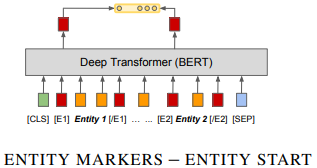

The new methods require the usage of special tokens. The following code will add the required tokens.

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

tokenizer_MTB = tokenizer

tokenizer_MTB.add_tokens(['<e1>', '</e1>', '<e2>', '</e2>'])

Create a new dataloader that add entity markers to the dataset and return their indexes as part of the new sample (the expected sample should be (s, l, i) where s is the sentence embedding, l is the label, and i is a touple with the indexes of the start entities)

In [ ]:
def prepare_data_MTB(data, tokenizer, batch_size=8):
    data_sequences = []
    # TODO - your code...

    return data_sequences

train_sequences = prepare_data_MTB(train, tokenizer)
test_sequences = prepare_data_MTB(test, tokenizer)

Create a new model that uses the "entity markers - Entity start" method.

In [ ]:
class MTB(nn.Module):
    def __init__(self, base_model_name):
      config = AutoConfig.from_pretrained(name)
      self.model = AutoModel.from_config(config)
      # TODO - your code...
    def forward(self, input, index):
      # TODO - your code...
model = MTB('bert-base-uncased')

Use the new dataloader and model to train and evaluate the new model as in task 4 and 5

In [ ]:
train_loop(model, n_epochs, train_data, dev_data)
evaluate(model, test_data)


**Good luck!**